# Stick flowers experiment

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import itertools
import numpy as np
from IPython.display import Image
from lineart import style, transform, draw
from lineart.primatives import EdgeCollection
import structlog

logger = structlog.get_logger()

# Perlin experiments

Note, as things stand both my numpy perlin and the one from the wiki seem to only work with a periodicity of 1 on a 2d plane of size 1, while the numpy perlin generates a grid, while i want to sample at an arbitrary point. 

## my numpy perlin

In [857]:
def interpolate(a0, a1, w):
    return (a1 - a0) * ((w * (w * 6.0 - 15.0) + 10.0) * w * w * w) + a0

In [858]:
resolution = 4
size = 1
unit = size / resolution
gradients = np.random.rand(resolution + 1, resolution + 1, 2)
gradients = np.array(
    [
        [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]],
        [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]],
        [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]],
        [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]],
        [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]],
    ]
)
# logger.info("gradients", shape=gradients.shape)
gradients = gradients / np.linalg.norm(gradients, axis=-1).reshape(
    resolution + 1, resolution + 1, 1
)
# logger.info("gradients", shape=gradients.shape)
cy, cx = np.meshgrid(
    np.linspace(0, 1, resolution + 1), np.linspace(0, 1, resolution + 1)
)
# logger.info("cy,cx,cz", shape=(cy.shape,cx.shape,cz.shape))
cell_node_lattice = np.stack([cx, cy])
# logger.info("cell_node_lattice", shape=cell_node_lattice.shape)
lattice = np.transpose(cell_node_lattice, axes=(1, 2, 0))
# logger.info("lattice", shape=lattice.shape)

In [859]:
lattice[0, 1]

array([0.  , 0.25])

In [860]:
point = np.array([0.27, 0.01])
cell_loc = (point / unit).astype(int)
cell_loc[cell_loc == resolution] = resolution - 1  # clamp to resolution
# logger.info("cell_loc", shape=cell_loc.shape, value=cell_loc, point=point, unit=unit, div = point/unit)
cell_gradients = gradients[
    cell_loc[0] : cell_loc[0] + 2, cell_loc[1] : cell_loc[1] + 2, :
]
# logger.info("cell_gradients", shape=cell_gradients.shape)
cell_points = lattice[cell_loc[0] : cell_loc[0] + 2, cell_loc[1] : cell_loc[1] + 2, :]
# logger.info("cell_points", shape=cell_points.shape, value=cell_points)
difference_vecs = cell_points - point
# logger.info("difference_vecs", shape=difference_vecs.shape)
cell_dots = (cell_gradients * difference_vecs).sum(axis=-1)
# logger.info("cell_dots", shape=cell_dots.shape)
weights = point - cell_points[0, 0]
# logger.info("weights", shape=weights.shape)
x_interp = interpolate(cell_dots[0, :], cell_dots[1, :], weights[0])
# logger.info("x_interp", shape=x_interp.shape)
y_interp = interpolate(x_interp[0], x_interp[1], weights[1])
# logger.info("y_interp", shape=y_interp.shape)
perlin_value = y_interp
# logger.info("perlin_value", shape=perlin_value.shape)
perlin_value

-0.010000098314851078

In [861]:
gradients[:, :, 1]

array([[1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1.]])

In [862]:
cell_loc

array([1, 0])

In [863]:
cell_points

array([[[0.25, 0.  ],
        [0.25, 0.25]],

       [[0.5 , 0.  ],
        [0.5 , 0.25]]])

In [864]:
difference_vecs

array([[[-0.02, -0.01],
        [-0.02,  0.24]],

       [[ 0.23, -0.01],
        [ 0.23,  0.24]]])

In [865]:
cell_gradients.shape

(2, 2, 2)

In [866]:
cell_dots

array([[-0.01, -0.02],
       [-0.01,  0.23]])

In [867]:
weights

array([0.02, 0.01])

In [868]:
interpolate(cell_dots[0, 0], cell_dots[1, 0], weights[0])
interpolate(cell_dots[0, 1], cell_dots[1, 1], weights[0])

-0.019980595200000017

In [869]:
cell_dots[0, :], cell_dots[1, :], weights[0], interpolate(
    cell_dots[0, :], cell_dots[1, :], weights[1]
)

(array([-0.01, -0.02]),
 array([-0.01,  0.23]),
 0.020000000000000018,
 array([-0.01      , -0.01999754]))

In [870]:
x_interp

array([-0.01     , -0.0199806])

In [871]:
y_interp

-0.010000098314851078

In [872]:
np.dot(np.array([0.02, 0.01]), np.array([0.96524238, 0.26135634]))

0.021918411000000002

In [873]:
cell_dots

array([[-0.01, -0.02],
       [-0.01,  0.23]])

In [891]:
# wrapper to print args and type hints
class Perlin2D:
    def __init__(self, size: int, resolution: int, seed=0):
        np.random.seed(seed)
        self.resolution = resolution
        self.size = size
        self.unit = size / resolution
        angles = np.pi * 2 * np.random.rand(resolution + 1, resolution + 1)
        self.gradients = np.stack([np.cos(angles), np.sin(angles)], axis=-1)

        # gradients = np.array(    [
        #                   [[0,1], [1,0], [0,1], [1,0], [0,1]],
        #                   [[0,1], [1,0], [0,1], [1,0], [0,1]],
        #                   [[0,1], [1,0], [0,1], [1,0], [0,1]],
        #                   [[0,1], [1,0], [0,1], [1,0], [0,1]],
        #                   [[0,1], [1,0], [0,1], [1,0], [0,1]],
        #             ])
        logger.info(
            "gradients",
            shape=self.gradients.shape,
            norms=np.linalg.norm(self.gradients, axis=-1),
        )
        cy, cx = np.meshgrid(
            np.linspace(0, 1, resolution + 1), np.linspace(0, 1, resolution + 1)
        )
        # logger.info("cy,cx,cz", shape=(cy.shape,cx.shape,cz.shape))
        cell_node_lattice = np.stack([cx, cy])
        # logger.info("cell_node_lattice", shape=cell_node_lattice.shape)
        self.lattice = np.transpose(cell_node_lattice, axes=(1, 2, 0))
        # logger.info("lattice", shape=lattice.shape)

    def __call__(self, point) -> float:
        cell_loc = (point / self.unit).astype(int)
        cell_loc[cell_loc == self.resolution] = self.resolution - 1  # clip to last cell
        # logger.info("cell_loc", shape=cell_loc.shape, value=cell_loc, point=point, unit=unit, div = point/unit)
        cell_gradients = self.gradients[
            cell_loc[0] : cell_loc[0] + 2, cell_loc[1] : cell_loc[1] + 2, :
        ]
        # logger.info("cell_gradients", shape=cell_gradients.shape)
        cell_points = self.lattice[
            cell_loc[0] : cell_loc[0] + 2, cell_loc[1] : cell_loc[1] + 2, :
        ]
        # logger.info("cell_points", shape=cell_points.shape, value=cell_points)
        difference_vecs = cell_points - point
        # logger.info("difference_vecs", shape=difference_vecs.shape)
        cell_dots = (cell_gradients * difference_vecs).sum(axis=-1)
        # logger.info("cell_dots", shape=cell_dots.shape)
        weights = point - cell_points[0, 0]
        # logger.info("weights", shape=weights.shape)
        x_interp = interpolate(cell_dots[0], cell_dots[1], weights[0])
        # logger.info("x_interp", shape=x_interp.shape)
        y_interp = interpolate(x_interp[0], x_interp[1], weights[1])
        # logger.info("y_interp", shape=y_interp.shape)
        perlin_value = y_interp
        # logger.info("perlin_value", shape=perlin_value.shape)
        return perlin_value

    def separate_call(self, point) -> float:
        cell_loc = (point / self.unit).astype(int)
        cell_loc[cell_loc == self.resolution] = self.resolution - 1

        g00 = self.gradients[cell_loc[0], cell_loc[1]]
        g01 = self.gradients[cell_loc[0], cell_loc[1] + 1]
        g10 = self.gradients[cell_loc[0] + 1, cell_loc[1]]
        g11 = self.gradients[cell_loc[0] + 1, cell_loc[1] + 1]

        p00 = self.lattice[cell_loc[0], cell_loc[1]]
        p01 = self.lattice[cell_loc[0], cell_loc[1] + 1]
        p10 = self.lattice[cell_loc[0] + 1, cell_loc[1]]
        p11 = self.lattice[cell_loc[0] + 1, cell_loc[1] + 1]

        dot00 = np.dot(g00, point - p00)
        dot01 = np.dot(g01, point - p01)
        dot10 = np.dot(g10, point - p10)
        dot11 = np.dot(g11, point - p11)

        weights = point - p00

        x_interp0 = interpolate(dot00, dot10, weights[0])
        x_interp1 = interpolate(dot01, dot11, weights[0])

        y_interp = interpolate(x_interp0, x_interp1, weights[1])

        return y_interp

In [892]:
perlin.gradients

array([[[ 0.96217097, -0.27244636],
        [-0.61790803, -0.78625038]],

       [[-0.88771752,  0.46038855],
        [-0.78475953, -0.61980036]]])

In [893]:
print(perlin(np.array([0, 0])))

0.0


In [894]:
print(perlin(np.array([1 / test_res, 1 / test_res])))

0.0


In [895]:
test_point = np.array([3 / test_res, 1 / test_res])
print(test_point)
print(perlin(test_point))

[3. 1.]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [896]:
perlin.gradients

array([[[ 0.96217097, -0.27244636],
        [-0.61790803, -0.78625038]],

       [[-0.88771752,  0.46038855],
        [-0.78475953, -0.61980036]]])

2024-06-06 16:43:10 [info     ] gradients                      norms=array([[1., 1.],
       [1., 1.]]) shape=(2, 2, 2)


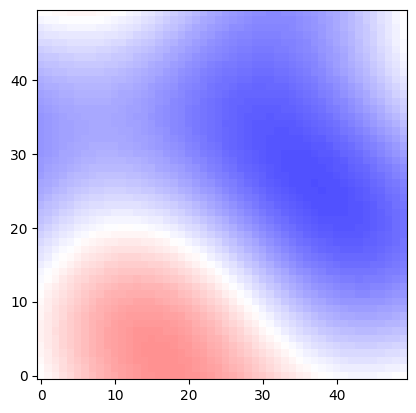

In [919]:
import matplotlib.pyplot as plt


test_res = 1
test_size = 1
sample_res = 50
perlin = Perlin2D(size=test_size, resolution=test_res, seed=3)

cx, cy = np.meshgrid(
    np.linspace(0, test_size, sample_res), np.linspace(0, test_size, sample_res)
)

sample_grid = np.stack([cx, cy]).transpose(1, 2, 0)
sample_grid.shape
perlin_grid = np.zeros((sample_res, sample_res))
for i in range(sample_res):
    for j in range(sample_res):
        perlin_grid[i, j] = perlin(sample_grid[i, j])


plt.imshow(perlin_grid, origin="lower", cmap="seismic", vmin=-1, vmax=1)

## Transpiled from c wiki page perlin

from https://en.wikipedia.org/wiki/Perlin_noise

In [ ]:
import math


def interpolate(a0, a1, w):
    """Function to linearly interpolate between a0 and a1
    Weight w should be in the range [0.0, 1.0]
    """
    return (a1 - a0) * ((w * (w * 6.0 - 15.0) + 10.0) * w * w * w) + a0


class Vector2:
    def __init__(self, x, y):
        self.x = x
        self.y = y


def random_gradient(ix, iy):
    """Create pseudorandom direction vector"""
    w = 8 * 32
    s = w // 2  # rotation width
    a = ix
    b = iy
    a *= 3284157443
    b ^= a << s | a >> w - s
    b *= 1911520717
    a ^= b << s | b >> w - s
    a *= 2048419325
    random = a * (3.14159265 / (2 ^ 31 - 1))  # in [0, 2*Pi]
    return Vector2(math.cos(random), math.sin(random))


def dot_grid_gradient(ix, iy, x, y):
    """Computes the dot product of the distance and gradient vectors."""
    gradient = random_gradient(ix, iy)

    # Compute the distance vector
    dx = x - float(ix)
    dy = y - float(iy)

    # Compute the dot-product
    return dx * gradient.x + dy * gradient.y


def perlin_wiki(x, y):
    """Compute Perlin noise at coordinates x, y"""
    # Determine grid cell coordinates
    x0 = int(math.floor(x))
    x1 = x0 + 1
    y0 = int(math.floor(y))
    y1 = y0 + 1

    # Determine interpolation weights
    sx = x - float(x0)
    sy = y - float(y0)

    # Interpolate between grid point gradients
    n0 = dot_grid_gradient(x0, y0, x, y)
    n1 = dot_grid_gradient(x1, y0, x, y)
    ix0 = interpolate(n0, n1, sx)

    n0 = dot_grid_gradient(x0, y1, x, y)
    n1 = dot_grid_gradient(x1, y1, x, y)
    ix1 = interpolate(n0, n1, sx)

    value = interpolate(ix0, ix1, sy)
    return value  # Will return in range -1 to 1. To make it in range 0 to 1, multiply by 0.5 and add 0.5

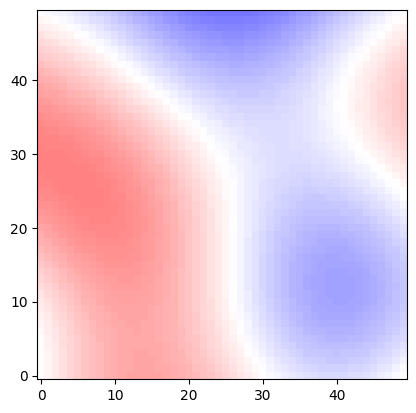

In [823]:
sample_res = 50
cx, cy = np.meshgrid(np.linspace(0, 1, sample_res), np.linspace(0, 1, sample_res))

sample_grid = np.stack([cx, cy]).transpose(1, 2, 0)
sample_grid.shape

perlin_grid = np.zeros((sample_res, sample_res))
for i in range(sample_res):
    for j in range(sample_res):
        perlin_grid[i, j] = perlin_wiki(*sample_grid[i, j])

import matplotlib.pyplot as plt

plt.imshow(perlin_grid, origin="lower", cmap="seismic", vmin=-1, vmax=1)

## perlin_numpy package example

from blog https://pvigier.github.io/2018/06/13/perlin-noise-numpy.html

by the author of https://github.com/pvigier/perlin-numpy/tree/master?tab=readme-ov-file

In [789]:
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6 * t**5 - 15 * t**4 + 10 * t**3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0 : res[0] : delta[0], 0 : res[1] : delta[1]].transpose(1, 2, 0) % 1
    logger.info("grid", shape=grid.shape, delta=delta, d=d, first_3=grid[:3, :3])

    # Gradients
    angles = 2 * np.pi * np.random.rand(res[0] + 1, res[1] + 1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    logger.info("gradients", shape=gradients.shape)
    g00 = gradients[0:-1, 0:-1].repeat(d[0], 0).repeat(d[1], 1)
    logger.info(
        "g00",
        shape=g00.shape,
        grad_slice=gradients[0:-1, 0:-1].shape,
        first_reapeat=gradients[0:-1, 0:-1].repeat(d[0], 0).shape,
        second_repeat=gradients[0:-1, 0:-1].repeat(d[0], 0).repeat(d[1], 1).shape,
    )
    g10 = gradients[1:, 0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1, 1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:, 1:].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:, :, 0] - 1, grid[:, :, 1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:, :, 0], grid[:, :, 1] - 1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:, :, 0] - 1, grid[:, :, 1] - 1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00 * (1 - t[:, :, 0]) + t[:, :, 0] * n10
    n1 = n01 * (1 - t[:, :, 0]) + t[:, :, 0] * n11
    return np.sqrt(2) * ((1 - t[:, :, 1]) * n0 + t[:, :, 1] * n1)

2024-06-06 15:25:17 [info     ] grid                           d=(100, 100) delta=(0.01, 0.01) first_3=array([[[0.  , 0.  ],
        [0.  , 0.01],
        [0.  , 0.02]],

       [[0.01, 0.  ],
        [0.01, 0.01],
        [0.01, 0.02]],

       [[0.02, 0.  ],
        [0.02, 0.01],
        [0.02, 0.02]]]) shape=(100, 100, 2)
2024-06-06 15:25:17 [info     ] gradients                      shape=(2, 2, 2)
2024-06-06 15:25:17 [info     ] g00                            first_reapeat=(100, 1, 2) grad_slice=(1, 1, 2) second_repeat=(100, 100, 2) shape=(100, 100, 2)


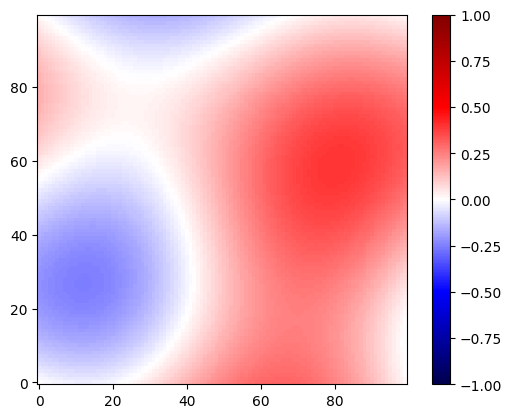

In [822]:
np.random.seed(0)
noise = generate_perlin_noise_2d(shape=(100, 100), res=(1, 1))
plt.imshow(noise, origin="lower", cmap="seismic", vmin=-1, vmax=1)
plt.colorbar()

# field of stems

In [920]:
perlin = Perlin2D(size=1, resolution=1, seed=3)

2024-06-06 16:43:35 [info     ] gradients                      norms=array([[1., 1.],
       [1., 1.]]) shape=(2, 2, 2)


In [948]:
np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))[0]

(50, 50)

In [951]:
points = np.random.rand(100, 2)
points = np.array(
    [[x, y] for x, y in itertools.product(np.linspace(0, 1, 20), np.linspace(0, 1, 20))]
)
p_vals = [perlin(p) for p in points]
logger.info(
    "p_vals", min=min(p_vals), max=max(p_vals), mean=np.mean(p_vals), std=np.std(p_vals)
)
used_points = np.array([p for p, v in zip(points, p_vals) if v > np.mean(p_vals) - 0.1])
used_p_vals = [v for v in p_vals if v > np.mean(p_vals) - 0.1]
len(used_points), len(used_p_vals)

2024-06-06 16:52:51 [info     ] p_vals                         max=0.21507061384136225 mean=-0.11716399371545012 min=-0.3430687173947645 std=0.15000041361683203


(280, 280)

Calling rotate_unison with args: [EdgeCollection at: object.__repr__(self)
self.edges.shape=(280, 2, 3)
self.centers.mean(axis=0)=array([ 0.41390977,  0.44868421, -0.19033471])self.lengths (min, mean, max) : (0.00, 0.93, 1.74)] and kwargs: {'p0': array([[0.5, 0.5, 0. ]]), 'normal': array([0, 0, 1]), 'theta': 0.19634954084936207}
Calling rotate_unison with args: [EdgeCollection at: object.__repr__(self)
self.edges.shape=(280, 2, 3)
self.centers.mean(axis=0)=array([ 0.40555276,  0.4664656 , -0.19033471])self.lengths (min, mean, max) : (0.00, 0.93, 1.74)] and kwargs: {'p0': array([[0.5, 0.5, 0. ]]), 'normal': array([1, 0, 0]), 'theta': -0.09817477042468103}


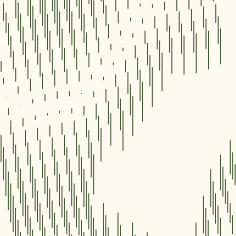

In [955]:
stems = EdgeCollection(
    np.array([[[*p, v * 8], [*p, 0]] for p, v in zip(used_points, used_p_vals)])
)
stems = (
    stems.rotate_unison(
        p0=[[0.5, 0.5, 0]], normal=[0, 0, 1], theta=np.pi / 16
    ).rotate_unison(p0=[[0.5, 0.5, 0]], normal=[1, 0, 0], theta=-np.pi / 32)
    # .rotate_unison(p0=[[0.5,0.5,0]], normal=[1,0,0],theta=np.pi)
)
page = draw.quick_draw_edges(
    stems.edges,
    v=False,
    image_size=100,
    edge_style=style.simple_edge(style.wildflower_greens[2]),
    unit_scale=True,
)
Image(page.image(kind="rgba", ppi=60).png())